# Inspiration
- https://medium.com/@xjurajkmec/pairwise-learning-for-neural-link-prediction-f1d16a0d28f6#:~:text=The%20idea%20of%20using%20graph,edges%20in%20the%20given%20graph
-

In [4]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch import torch

In [5]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')

postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

In [6]:
from sklearn import preprocessing

post_article = postings.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ArticlePublishingDate": "min"})
post_article = post_article.reset_index()
votes_trunc = votes[['ID_CommunityIdentity', 'ID_Posting']]
postings_trunc = postings.groupby(by = ['ID_Posting', 'ID_Article']).agg({"ArticlePublishingDate": "min"}).reset_index().drop(columns = ['ArticlePublishingDate'])
vote_user_article = votes_trunc.merge(postings_trunc, left_on = ['ID_Posting'], right_on = ['ID_Posting'])
vote_article = vote_user_article.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ID_Posting": "count"}).reset_index().drop(columns = ['ID_Posting'])
user_article_interaction = pd.concat([post_article, vote_article]).drop(columns=['ArticlePublishingDate'])

In [7]:
# subset edges
# user_article_interaction = user_article_interaction.sample(n=int(user_article_interaction.shape[0]/20), random_state=1)
user_article_interaction = user_article_interaction.iloc[:int(user_article_interaction.shape[0]/4), :]

In [8]:
user_article_interaction.shape

(272983, 2)

In [9]:
user_article_interaction["user_id"] = "u-" + user_article_interaction["ID_CommunityIdentity"].astype(str)
user_article_interaction["article_id"] = "a-" + user_article_interaction["ID_Article"].astype(str)

nodes = np.concatenate((np.unique(user_article_interaction['user_id']), np.unique(user_article_interaction['article_id'])))
nodes_user = np.unique(user_article_interaction['user_id'])
nodes_article = np.unique(user_article_interaction['article_id'])

label_encoder_nodes = preprocessing.LabelEncoder()
label_encoder_nodes.fit(nodes)
nodes_enc = label_encoder_nodes.transform(nodes)

user_article_interaction["user_id_enc"] = label_encoder_nodes.transform(user_article_interaction["user_id"])
user_article_interaction["article_enc"] = label_encoder_nodes.transform(user_article_interaction["article_id"])

In [10]:
edge_list = []
for row in user_article_interaction.itertuples():
    edge_list.append([row.user_id_enc, row.article_enc])

from torch_geometric.data import Data

x = torch.tensor(nodes_enc, dtype=torch.long)
edge_index = torch.tensor(edge_list, dtype=torch.long)
graph = Data(x=x, edge_index=edge_index.t())

graph.validate(raise_on_error=True)


True

In [11]:
from torch_geometric.transforms.to_undirected import ToUndirected
graph = ToUndirected()(graph)


In [12]:
graph

Data(x=[22426], edge_index=[2, 545966])

In [13]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Cuda is available: ", torch.cuda.is_available())

Cuda is available:  True


In [14]:
graph.edge_index.to(device)

tensor([[    0,     1,     2,  ..., 22425, 22425, 22425],
        [14443,  8027,  4315,  ...,  3420,  3848,  4040]], device='cuda:0')

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator #needed to extract and evaluate the ogb-ddi dataset
import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np 

In [43]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()
        conv_model = pyg.nn.SAGEConv

        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        # Create num_layers GraphSAGE convs
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing processing 
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return final layer of embeddings if specified
        if self.emb:
            return x

        # Else return class probabilities
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [44]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

In [45]:
import subprocess as sp
import os
from tqdm import tqdm

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [219]:
def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer, debug=False):
    """
    Runs offline training for model, link_predictor and node embeddings given the message
    edges and supervision edges.
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param pos_train_edge: (PE, 2) Positive edges used for training supervision loss
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param optimizer: Torch Optimizer to update model parameters
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    model.train()
    link_predictor.train()
    train_losses = []
    # define data loader for edges
    # dataloader = DataLoader(pos_train_edge, batch_size=batch_size, shuffle=True)
    # print(pos_train_edge.shape[1])
    pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
    dataloader = DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True)
    # dataloader = DataLoader(range(pos_train_edge.shape[1]), batch_size, shuffle=True)
    i = 0
    # print(pos_train_edge)
    for edge_id in dataloader:
        # print(edge_id)
        # print(edge_id)
        i+=1
        
        optimizer.zero_grad()
        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        # pos_edge = pos_train_edge.T[edge_id]  # (2, B)
        pos_edge = pos_train_edge[edge_id]  # (2, B)

        # pos_pred = link_predictor(node_emb[pos_edge.T[0]], node_emb[pos_edge.T[1]])  # (B, )
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )
        

        # print("Number of negative edges to sample: ", edge_id.shape[0])
        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = negative_sampling(edge_index, num_nodes=emb.shape[0],
                                    num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
        # print("Train loss: ", loss)

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        if debug:
            print("Train edges batch shape: ", edge_id.shape)
            print("Train node embedding shape: ", node_emb.shape)
            print("Train positive edge shape: ", pos_edge.shape)
            print("Shape of positive edges (source): ", pos_edge.T[0].shape)
            print("Shape of positive edges (target): ", pos_edge.T[1].shape)
            print("Node embedding shape: ", node_emb[pos_edge[0]].shape)
            print("Train positive prediction shape: ", pos_pred.shape)
            print("Train negative prediction shape: ", neg_pred.shape)
    if debug:
        print("Train losses: ", train_losses)
        print("Train losses length: ", i)

    print("Train loss: ", sum(train_losses) / len(train_losses))

    return sum(train_losses) / len(train_losses)

In [220]:
get_gpu_memory()

[427]

In [221]:
# from utils import do_edge_split
# split_edge = do_edge_split(graph, fast_split = False)

In [222]:
# def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
#     """
#     Evaluates graph model on validation and test edges
#     :param model: Torch Graph model used for updating node embeddings based on message passing
#     :param predictor: Torch model used for predicting whether edge exists or not
#     :param emb: (N, d) Initial node embeddings for all N nodes in graph
#     :param edge_index: (2, E) Edge index for all edges in the graph
#     :param split_edge: Dictionary of (e, 2) edges for val pos/neg and test pos/neg edges
#     :param batch_size: Number of positive (and negative) supervision edges to sample per batch
#     :param evaluator: OGB evaluator to calculate hits @ k metric
#     :return: hits @ k results
#     """
    # model.eval()
    # predictor.eval()

    # node_emb = model(emb, edge_index)

#     pos_valid_edge = split_edge['valid']['edge'].T.to(emb.device)
#     neg_valid_edge = split_edge['valid']['edge_neg'].T.to(emb.device)
#     pos_test_edge = split_edge['test']['edge'].T.to(emb.device)
#     neg_test_edge = split_edge['test']['edge_neg'].T.to(emb.device)
    
#     # pos_valid_pred = []
#     # for perm in DataLoader(range(pos_valid_edge.size(1)), batch_size):
#     #     edges = pos_valid_edge[perm].t()
#     #     for edge in edges:
#     #         pos_valid_pred.append(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu())
#     # pos_valid_pred = torch.tensor(pos_valid_pred)

#     # neg_valid_preds = []
#     # for perm in DataLoader(range(neg_valid_preds.size(1)), batch_size):
#     #     edges = neg_valid_preds[perm].t()
#     #     for edge in edges:
#     #         pos_valid_pred.append(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu())
#     # neg_valid_preds = torch.tensor(neg_valid_preds)
    
    
#     # compute loss for validation set
#     # loss_val = -torch.log(pos_valid_pred + 1e-15).mean() - torch.log(1 - neg_valid_preds + 1e-15).mean()
    
#     # print(edge)
#     #     pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#     #     print(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu())
#     # pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

#     # print(pos_valid_pred)

#     with torch.no_grad():

#         loss_val_pos = []
#         pos_valid_preds = []
#         for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
#             edge = pos_valid_edge[perm].t()
#             pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#             loss_val_pos.append(-torch.log(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
#         pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
#         loss_val_pos_val = sum(loss_val_pos) / len(loss_val_pos)

#         loss_val_neg = []
#         neg_valid_preds = []
#         for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
#             edge = neg_valid_edge[perm].t()
#             neg_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#             loss_val_neg.append(-torch.log(1 - predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
#         neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
#         loss_val_neg_val = sum(loss_val_neg) / len(loss_val_neg)

#         loss_test_pos = []
#         pos_test_preds = []
#         for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
#             edge = pos_test_edge[perm].t()
#             pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#             loss_test_pos.append(-torch.log(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
#         pos_test_pred = torch.cat(pos_test_preds, dim=0)
#         loss_test_pos_val = sum(loss_test_pos) / len(loss_test_pos)

#         loss_test_neg = []
#         neg_test_preds = []
#         for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
#             edge = neg_test_edge[perm].t()
#             neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
#             loss_test_neg.append(-torch.log(1 - predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
#         neg_test_pred = torch.cat(neg_test_preds, dim=0)
#         loss_test_neg_val = sum(loss_test_neg) / len(loss_test_neg)

#         results = {}
#         results["loss_val_pos"] = loss_val_pos_val
#         results["loss_val_neg"] = loss_val_neg_val
#         results["loss_test_pos"] = loss_test_pos_val
#         results["loss_test_neg"] = loss_test_neg_val

#         print("Loss val pos: ", loss_val_pos_val)
#         print("Loss val neg: ", loss_val_neg_val)
#         print("Loss test pos: ", loss_test_pos_val)
#         print("Loss test neg: ", loss_test_neg_val)


#     # print(pos_valid_pred.shape)
#     # print(neg_valid_pred.shape)

#     # calculate roc auc with sklearn with tensors
#     # from sklearn.metrics import roc_auc_score
#     # roc_auc = roc_auc_score(torch.cat([torch.ones(pos_valid_pred.shape[0]), torch.zeros(neg_valid_pred.shape[0])]).detach().numpy(), 
#     #                         torch.cat([pos_valid_pred, neg_valid_pred]).detach().numpy())
    
#     # print("ROC AUC: ", roc_auc)
#     # for K in [20, 50, 100]:
#     #     evaluator.K = K
#     #     valid_hits = evaluator.eval({
#     #         'y_pred_pos': pos_valid_pred,
#     #         'y_pred_neg': neg_valid_pred,
#     #     })[f'hits@{K}']
#     #     test_hits = evaluator.eval({
#     #         'y_pred_pos': pos_test_pred,
#     #         'y_pred_neg': neg_test_pred,
#     #     })[f'hits@{K}']

#     #     results[f'Hits@{K}'] = (valid_hits, test_hits)
#         # results[f'Hits@{K}'] = (test_hits)

#     # calculate auc

#     # print(pos_valid_pred)
#     # print(neg_valid_pred)

#     # valid_auc = evaluator.eval({
#     #     'y_pred_pos': pos_valid_pred,
#     #     'y_pred_neg': neg_valid_pred,
#     # })['rocauc']
#     # test_auc = evaluator.eval({
#     #     'y_pred_pos': pos_test_pred,
#     #     'y_pred_neg': neg_test_pred,
#     # })['rocauc']
#     # results['AUC'] = (valid_auc, test_auc)
    

#     return results

def select_user_article_negative_edges(label_encoder_nodes, edges):
    
    # edges = edges.T
    
    sources = edges[0]
    targets = edges[1]

    sources_is_article = pd.Series(label_encoder_nodes.inverse_transform(sources)).apply(lambda x: x.startswith("a-"))
    targets_is_article = pd.Series(label_encoder_nodes.inverse_transform(targets)).apply(lambda x: x.startswith("a-"))

    mask = (sources_is_article & ~targets_is_article) | (~sources_is_article & targets_is_article)

    sources_masked = sources[mask]
    targes_masked = targets[mask]

    new_edges = np.vstack((sources_masked, targes_masked))
    # print(sources_masked)
    return torch.tensor(new_edges)

from sklearn.metrics import roc_auc_score

def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):

    device = 'cuda' if torch.cuda.is_available() else "cpu"

    pos_valid_edge = split_edge['valid']['edge'].T.to(device)
    neg_valid_edge = select_user_article_negative_edges(label_encoder_nodes, split_edge['valid']['edge_neg'])
    neg_valid_edge = neg_valid_edge.T.to(device)
    # neg_valid_edge = split_edge['valid']['edge_neg'].T.to(device)
    pos_test_edge = split_edge['test']['edge'].T.to(device)
    # neg_test_edge = split_edge['test']['edge_neg'].T.to(device)
    neg_test_edge = select_user_article_negative_edges(label_encoder_nodes, split_edge['test']['edge_neg'])
    neg_test_edge = neg_test_edge.T.to(device)

    # model = models["model"]
    # predictor = models["link_predictor"]
    # node_emb = models["emb"].weight

    model.eval()
    predictor.eval()

    node_emb = model(emb, edge_index)

    # model.eval()
    # predictor.eval()
    # node_emb = model(emb, edge_index)

    with torch.no_grad():


        # valid_loss = []
        valid_pos_preds = []
        for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
            edge_pos = pos_valid_edge[perm].t()
            pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
            valid_pos_preds += [pos_preds]
        # pred_labels_val = torch.cat(valid_pos_preds).detach().numpy()
        
        valid_neg_preds = []
        for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
            edge_neg = neg_valid_edge[perm].t()
            neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
            valid_neg_preds += [neg_preds]
        
        pred_labels_val = torch.cat([torch.cat(valid_pos_preds), torch.cat(valid_neg_preds)])
        true_labels_val = torch.cat([torch.ones(pos_valid_edge.shape[0]), torch.zeros(neg_valid_edge.shape[0])])
        loss_val = -torch.log(pred_labels_val + 1e-15).mean() - torch.log(1 - pred_labels_val + 1e-15).mean()
        roc_auc_val = roc_auc_score(true_labels_val, pred_labels_val)


        # test_loss = []
        test_pos_preds = []
        for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
            edge_pos = pos_test_edge[perm].t()
            pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
            test_pos_preds += [pos_preds]
        # pred_labels_test = torch.cat(test_pos_preds).detach().numpy()

        test_neg_preds = []
        for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
            edge_neg = neg_test_edge[perm].t()
            neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
            test_neg_preds += [neg_preds]

        pred_labels_test = torch.cat([torch.cat(test_pos_preds), torch.cat(test_neg_preds)])
        true_labels_test = torch.cat([torch.ones(pos_test_edge.shape[0]), torch.zeros(neg_test_edge.shape[0])])
        loss_test = -torch.log(pred_labels_test + 1e-15).mean() - torch.log(1 - pred_labels_test + 1e-15).mean()
        roc_auc_test = roc_auc_score(true_labels_test, pred_labels_test)


        # valid_pos_preds = []
        # valid_neg_preds = []
        # for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        #     edge_pos = pos_valid_edge[perm].t()
        #     edge_neg = neg_valid_edge[perm].t()

        #     # edge_neg = select_user_article_negative_edges(label_encoder_nodes, edge_neg)
        #     pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
        #     valid_pos_preds += [pos_preds]
        #     neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
        #     valid_neg_preds += [neg_preds]
        #     loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
        #     valid_loss.append(loss.item())
        
        # true_labels_val = torch.cat([torch.ones(pos_valid_edge.shape[0]), torch.zeros(neg_valid_edge.shape[0])]).detach().numpy()
        # pred_labels_val = torch.cat([torch.cat(valid_pos_preds), torch.cat(valid_neg_preds)]).detach().numpy()
        
        # roc_auc_val = roc_auc_score(true_labels_val, pred_labels_val)

        # valid_loss = []
        # valid_pos_preds = []
        # valid_neg_preds = []
        # for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        #     edge_pos = pos_valid_edge[perm].t()
        #     edge_neg = neg_valid_edge[perm].t()

        #     # edge_neg = select_user_article_negative_edges(label_encoder_nodes, edge_neg)
        #     pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
        #     valid_pos_preds += [pos_preds]
        #     neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
        #     valid_neg_preds += [neg_preds]
        #     loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
        #     valid_loss.append(loss.item())
        
        # true_labels_val = torch.cat([torch.ones(pos_valid_edge.shape[0]), torch.zeros(neg_valid_edge.shape[0])]).detach().numpy()
        # pred_labels_val = torch.cat([torch.cat(valid_pos_preds), torch.cat(valid_neg_preds)]).detach().numpy()
        
        # roc_auc_val = roc_auc_score(true_labels_val, pred_labels_val)
        # # print("Validation ROC AUC: ", roc_auc_val)
        # # print("Validation loss: ", sum(valid_loss) / len(valid_loss))

        # test_loss = []
        # test_pos_preds = []
        # test_neg_preds = []
        # for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        #     edge_pos = pos_test_edge[perm].t()
        #     edge_neg = neg_test_edge[perm].t()
        #     # edge_neg = select_user_article_negative_edges(label_encoder_nodes, edge_neg)
        #     pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
        #     test_pos_preds += [pos_preds]
        #     neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
        #     test_neg_preds += [neg_preds]
        #     loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
        #     test_loss.append(loss.item())

        # true_labels_test = torch.cat([torch.ones(pos_test_edge.shape[0]), torch.zeros(neg_test_edge.shape[0])]).detach().numpy()
        # pred_labels_test = torch.cat([torch.cat(test_pos_preds), torch.cat(test_neg_preds)]).detach().numpy()
        # roc_auc_test = roc_auc_score(true_labels_test, pred_labels_test)
        # # print("Test ROC AUC: ", roc_auc_test)
        # # print("Test loss: ", sum(test_loss) / len(test_loss))

        results = {}
        results["loss_val"] = loss_val #sum(valid_loss) / len(valid_loss)
        results["loss_test"] = loss_test # sum(test_loss) / len(test_loss)
        results["roc_auc_val"] = roc_auc_val
        results["roc_auc_test"] = roc_auc_test

        print(results)
        return results

In [223]:
# select_user_article_negative_edges(label_encoder_nodes, split_edge['valid']['edge_neg'].T)

In [224]:
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit

# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = "cpu"
optim_wd = 0
epochs = 30
hidden_dim = 256
dropout = 0.3
num_layers = 1 # 1 - works pretty good 
lr = 5e-5
node_emb_dim = 256
batch_size = 512

In [225]:
from utils import create_train_test_split_rls
split_edge = create_train_test_split_rls(graph)

Train edges:  torch.Size([2, 218387])
Valid positive edges:  torch.Size([2, 27298])
Valid negative edges:  torch.Size([2, 27298])
Test positive edges:  torch.Size([2, 27298])
Test negative edges:  torch.Size([2, 27298])


In [226]:
evaluator = Evaluator(name='ogbl-ddi')
print(evaluator.expected_input_format)

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.


In [227]:
split_edge['train']['edge']

tensor([[ 2736,  2320,   303,  ...,  3779,  3334,  4001],
        [15513, 17085,  7049,  ..., 13797, 18972, 12727]])

In [228]:
split_edge['valid']['edge']

tensor([[ 3777,   518,  3394,  ...,   604,  3661,  3959],
        [18228, 21466,  5400,  ...,  9603, 16293, 16506]])

In [229]:
split_edge['test']['edge']

tensor([[   25,   343,  4137,  ...,  3972,  1753,   718],
        [19226, 15830, 10654,  ...,  8938, 15196, 16850]])

In [230]:
# https://colab.research.google.com/drive/1mzvskulGoM9uXCkc4Cke3_Ch0-lz_HnN#scrollTo=gG6mGvs9Uqnt

pos_train_edge = split_edge['train']['edge'].to(device)

emb = torch.nn.Embedding(graph.num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

# define evaluator for roc-auc
evaluator = Evaluator(name='ogbl-ddi')
# evaluator.expected_input_format


optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = graph.edge_index.to(device)

print("Before training. Available GPU memory: ", get_gpu_memory())

train_loss = []
loss_val_pos_list = []
loss_val_neg_list = []
loss_test_pos_list = []
loss_test_neg_list = []

loss_val_list = []
loss_testlist = []
loss_val_roc_auc_list = []
loss_test_roc_auc_list = []

val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    
    train_loss.append(loss)
    if (e+1)%50 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    
    result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
    
    # loss_val_pos_list.append(result["loss_val_pos"])
    # loss_val_neg_list.append(result["loss_val_neg"])
    # loss_test_pos_list.append(result["loss_test_pos"])
    # loss_test_neg_list.append(result["loss_test_neg"])
    loss_val_list.append(result["loss_val"])
    loss_testlist.append(result["loss_test"])
    loss_val_roc_auc_list.append(result["roc_auc_val"])
    loss_test_roc_auc_list.append(result["roc_auc_test"])
    
    # print("Validation positive edges loss: ", loss_val_pos_list)
    # print("Validation negative edges loss: ", loss_val_neg_list)
    # print("Test positive edges loss: ", loss_test_pos_list)
    # print("Test negative edges loss: ", loss_test_neg_list)

    

    # val_hits.append(result['Hits@20'][0])
    # test_hits.append(result['Hits@20'][1])
    # if (e+1)%50 ==0:
    #     print(result)


Before training. Available GPU memory:  [427]


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_158677/593965580.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
  0%|          | 0/30 [00:00<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

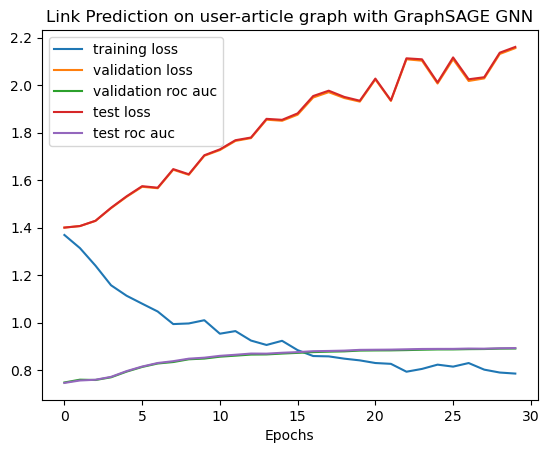

In [217]:
plt.title('Link Prediction on user-article graph with GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(loss_val_list,label="validation loss")
plt.plot(loss_val_roc_auc_list,label="validation roc auc")
plt.plot(loss_testlist, label = "test loss")
plt.plot(loss_test_roc_auc_list, label = "test roc auc")
# plt.plot(train_loss,label="training loss")
# plt.plot(loss_val_pos_list,label="validation loss positive")
# plt.plot(loss_val_neg_list,label="validation loss negative")
# plt.plot(loss_test_pos_list,label="test loss positive")
# plt.plot(loss_test_neg_list,label="test loss negative")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [218]:
# save models

hyper_params = {
    "optim_wd": optim_wd,
    "epochs": epochs,
    "hidden_dim": hidden_dim,
    "dropout": dropout,
    "num_layers": num_layers,
    "lr": lr,
    "node_emb_dim": node_emb_dim,
    "batch_size": batch_size
}

custom_param = "_negsample_ua"

model_dir = "./models" + "_layers" + str(hyper_params["num_layers"]) + \
      "_batch_size" + str(hyper_params["batch_size"]) + \
      "_epochs" + str(hyper_params["epochs"]) + custom_param + "/"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(hyper_params, model_dir + "hyper_params.pt")
torch.save(model.state_dict(), model_dir + "model.pt")
torch.save(link_predictor.state_dict(), model_dir + "link_predictor.pt")
torch.save(emb.state_dict(), model_dir + "emb.pt")

# torch.save(hyper_params, "hyper_params.pt")
# torch.save(model.state_dict(), "model.pt")
# torch.save(link_predictor.state_dict(), "link_predictor.pt")
# torch.save(emb.state_dict(), "emb.pt")


In [78]:
models = {}
models["model"] = model
models["link_predictor"] = link_predictor
models["emb"] = emb



In [84]:
model

GNNStack(
  (convs): ModuleList(
    (0): SAGEConv(256, 256, aggr=mean)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [ ]:
model, predictor, emb, edge_index, split_edge, batch_size, evaluator

In [96]:
from sklearn.metrics import roc_auc_score

def calculate_roc_auc(models, split_edge, batch_size):
    
    device = 'cuda' if torch.cuda.is_available() else "cpu"

    pos_valid_edge = split_edge['valid']['edge'].T.to(device)
    neg_valid_edge = split_edge['valid']['edge_neg'].T.to(device)
    
    pos_test_edge = split_edge['test']['edge'].T.to(device)
    neg_test_edge = split_edge['test']['edge_neg'].T.to(device)

    model = models["model"]
    predictor = models["link_predictor"]
    node_emb = models["emb"].weight

    model.eval()
    predictor.eval()
    # node_emb = model(emb, edge_index)

    with torch.no_grad():

        valid_loss = []
        valid_pos_preds = []
        valid_neg_preds = []
        for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
            edge_pos = pos_valid_edge[perm].t()
            edge_neg = neg_valid_edge[perm].t()
            pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
            valid_pos_preds += [pos_preds]
            neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
            valid_neg_preds += [neg_preds]
            loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
            valid_loss.append(loss.item())
        
        true_labels_val = torch.cat([torch.ones(pos_valid_edge.shape[0]), torch.zeros(neg_valid_edge.shape[0])]).detach().numpy()
        pred_labels_val = torch.cat([torch.cat(valid_pos_preds), torch.cat(valid_neg_preds)]).detach().numpy()
        
        roc_auc = roc_auc_score(true_labels_val, pred_labels_val)
        print("Validation ROC AUC: ", roc_auc)
        print("Validation loss: ", sum(valid_loss) / len(valid_loss))

        test_loss = []
        test_pos_preds = []
        test_neg_preds = []
        for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
            edge_pos = pos_test_edge[perm].t()
            edge_neg = neg_test_edge[perm].t()
            pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
            test_pos_preds += [pos_preds]
            neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
            test_neg_preds += [neg_preds]
            loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
            test_loss.append(loss.item())

        true_labels_test = torch.cat([torch.ones(pos_test_edge.shape[0]), torch.zeros(neg_test_edge.shape[0])]).detach().numpy()
        pred_labels_test = torch.cat([torch.cat(test_pos_preds), torch.cat(test_neg_preds)]).detach().numpy()
        roc_auc = roc_auc_score(true_labels_test, pred_labels_test)
        print("Validation ROC AUC: ", roc_auc)
        print("Test loss: ", sum(test_loss) / len(test_loss))

        # # loss_val_pos = []
        # pos_valid_preds = []
        # for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        #     edge = pos_valid_edge[perm].t()
        #     pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
        #     # loss_val_pos.append(-torch.log(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
        # pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
        # # loss_val_pos_val = sum(loss_val_pos) / len(loss_val_pos)

        # # loss_val_neg = []
        # neg_valid_preds = []
        # for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        #     edge = neg_valid_edge[perm].t()
        #     neg_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
        #     # loss_val_neg.append(-torch.log(1 - predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
        # neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
        # # loss_val_neg_val = sum(loss_val_neg) / len(loss_val_neg)

        # loss = -torch.log(pos_valid_pred + 1e-15).mean() - torch.log(1 - neg_valid_pred + 1e-15).mean()
        # print(loss)

        # # loss_test_pos = []
        # pos_test_preds = []
        # for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        #     edge = pos_test_edge[perm].t()
        #     pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
        #     # loss_test_pos.append(-torch.log(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
        # pos_test_pred = torch.cat(pos_test_preds, dim=0)
        # # loss_test_pos_val = sum(loss_test_pos) / len(loss_test_pos)

        # # loss_test_neg = []
        # neg_test_preds = []
        # for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        #     edge = neg_test_edge[perm].t()
        #     neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
        #     # loss_test_neg.append(-torch.log(1 - predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu() + 1e-15).mean())
        # neg_test_pred = torch.cat(neg_test_preds, dim=0)
        # # loss_test_neg_val = sum(loss_test_neg) / len(loss_test_neg)

        # loss = -torch.log(pos_test_pred + 1e-15).mean() - torch.log(1 - neg_test_pred + 1e-15).mean()
        # print(loss)

        # results = {}
        # results["loss_val_pos"] = loss_val_pos_val
        # results["loss_val_neg"] = loss_val_neg_val
        # results["loss_test_pos"] = loss_test_pos_val
        # results["loss_test_neg"] = loss_test_neg_val

        # print("Loss val pos: ", loss_val_pos_val)
        # print("Loss val neg: ", loss_val_neg_val)
        # print("Loss test pos: ", loss_test_pos_val)
        # print("Loss test neg: ", loss_test_neg_val)

calculate_roc_auc(models, split_edge, batch_size)
    

Validation ROC AUC:  0.49675775867141103
Validation loss:  2.5172901815838284
Validation ROC AUC:  0.49537681327604355
Test loss:  2.5080946683883667
